In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import set_matplotlib_formats


set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [12., 8.]

In [2]:
from models.hardnet_segm import HardNetSegm
import cv2
import torch
from models.bts_estimator import BTSEstimator
from plane_detector import PlaneDetector
from models.midas_estimator import MIDASEstimator
from ransac_detector import *

In [3]:
hardnet_path = "models/segmnetator/hardnet70_cityscapes_model_2.pkl"
bts_path = "models/depth_estimator/models/bts_latest"


depth_model = MIDASEstimator()
segm_model = HardNetSegm(hardnet_path)

Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/ruslan/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /home/ruslan/.cache/torch/hub/intel-isl_MiDaS_master


In [4]:
model = PlaneDetector(depth_model, segm_model)

In [5]:
%%time 
import os
import seaborn as sns
from tqdm import tqdm


path = "/home/ruslan/Документы/startup/FCHarDNet/data/leftImg8bit/val/frankfurt/"
files = os.listdir(path)

images = [cv2.imread(path + item) for item in tqdm(files)]

100%|██████████| 267/267 [00:17<00:00, 15.00it/s]


CPU times: user 17 s, sys: 933 ms, total: 18 s
Wall time: 18.1 s


In [30]:
from models.depth_estimator.BTS import BtsController
import numpy as np
from functools import partial
import copy


def thr_func(q):
    return partial(np.quantile, q=q)

# img = cv2.imread("/home/ruslan/Документы/startup/research/data/paris/61_location_48.8690788,2.3975894/120/gsv_0.jpg")
# img = cv2.imread("/home/ruslan/Загрузки/72ac1342-b976-48ad-9c20-9197707c7e62.jpeg")
# img = cv2.imread("/home/ruslan/Загрузки/test_corner2.jpg")
img = copy.deepcopy(images[123])
img = cv2.resize(img, (640, 480))

# seg_map = model.get_segm_map(img)
# depth_map = model.get_depth_map(img)
# # depth_img = BtsController.depth_map_to_rgbimg(depth_map)
        
# vect_func = np.vectorize(lambda x: x in set([0, 1]))
# map_arr = vect_func(seg_map)
depth_map, seg_map, ls_map_arr = model.get_segmented_depth(img, [{0, 1}, {2}])

In [31]:
N = 640 * 480

In [32]:
ls_right_depths = []
ls_tmp = []
funcs = [thr_func(0.95), np.mean]
for item, fun in zip(ls_map_arr, funcs):
    tmp, k = crop_depth_map((1 / depth_map) * item, fun)
    if k >= int(N * 0.2):
        ls_right_depths.extend(get_connected_components(tmp, threshold=0.5))


155965
22473
41754
396
280


In [33]:
import open3d as o3d
import os
import sys
import cv2

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# target = o3d.geometry.Image(np.float32(depth_maps[0]))


In [34]:
import random


def get_plane_img(img, ls_map_arrs, ls_inliers):
    """
    Function to plot detected planes on picture
    :param img:
    :param ls_map_arrs:
    :param ls_inliers:
    :return:
    """
    res = copy.deepcopy(img)
    for map_arr, inlier in zip(ls_map_arrs, ls_inliers):
        ls = np.argwhere(map_arr)
        np_ls = np.array(ls)
        color = [random.randint(0, 255) for _ in range(3)]
        for i, j in np_ls[inlier]:
            res[i][j] = color
    return res


In [35]:
%%time
ls_right_map_arrs = [np.where(item > 0, 1, 0) for item in ls_right_depths]
ls_pcd = []
ls_inliers, ls_clouds = [], []
for item in ls_right_depths:
    tmp = o3d.geometry.Image(item)
    tt = o3d.geometry.PointCloud.create_from_depth_image(
    tmp,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
    tt.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    ls_pcd.append(tt)
    arr = np.asarray(tt.points)
    th = abs(np.max(arr) - np.min(arr)) / 100
    plane_model, inliers = tt.segment_plane(distance_threshold=th,
                                         ransac_n=3,
                                         num_iterations=100)
    inlier_cloud = tt.select_by_index(inliers)
    
    inlier_cloud.paint_uniform_color([random.uniform(0, 1) for _ in range(3)])
    outlier_cloud = tt.select_by_index(inliers, invert=True)
    ls_inliers.append(inliers)
    ls_clouds.append(outlier_cloud)
    ls_clouds.append(inlier_cloud)

CPU times: user 245 ms, sys: 0 ns, total: 245 ms
Wall time: 244 ms


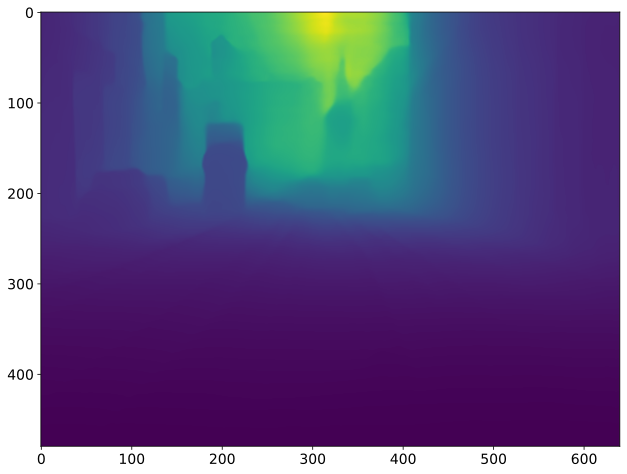

In [36]:
plt.imshow(1 / depth_map)

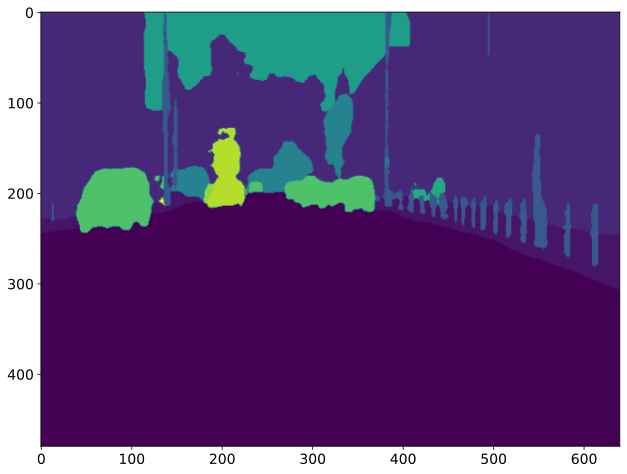

In [37]:
plt.imshow(seg_map)

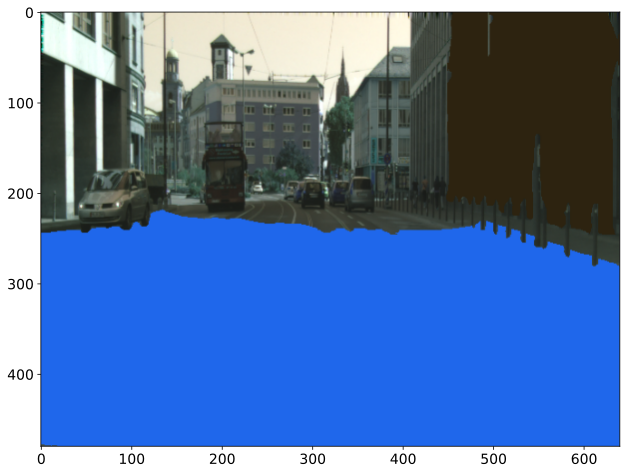

In [38]:
plt.imshow(get_plane_img(img, ls_right_map_arrs, ls_inliers))

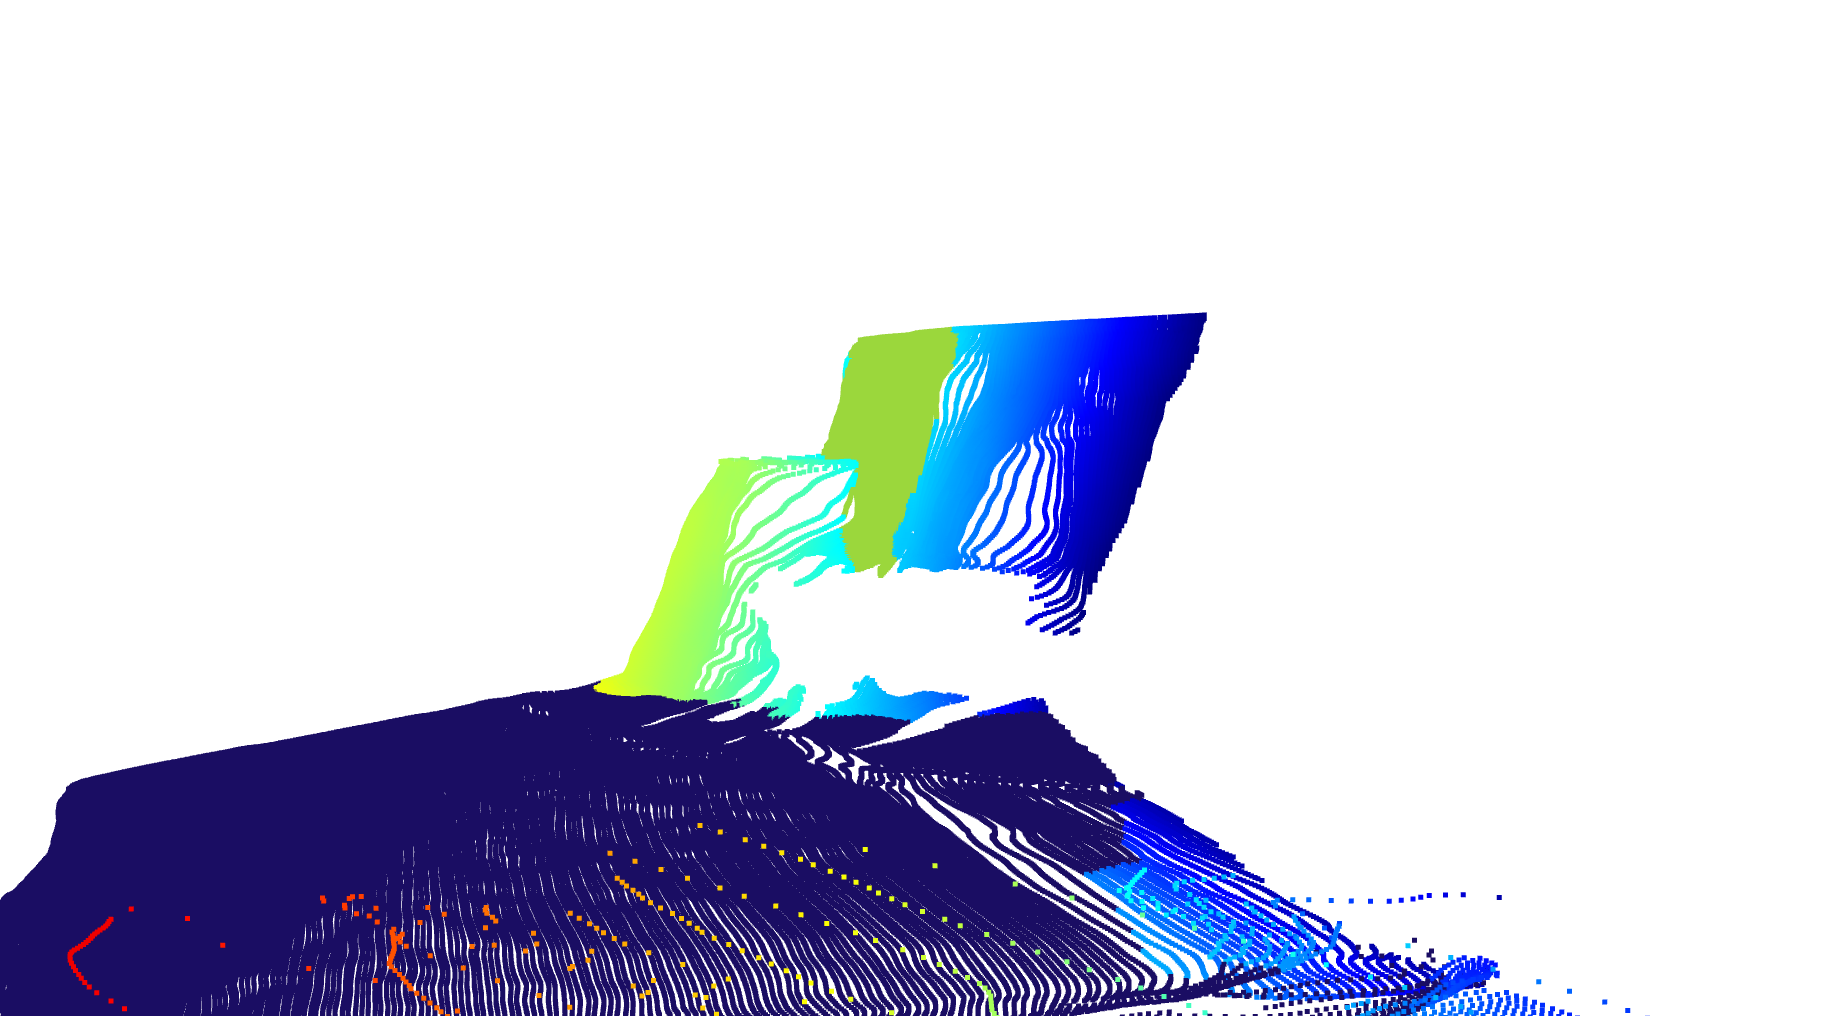

In [29]:
o3d.visualization.draw_geometries(ls_clouds, zoom=0.35)

In [32]:
downs = pcd.voxel_down_sample(0.000005)

NameError: name 'pcd' is not defined

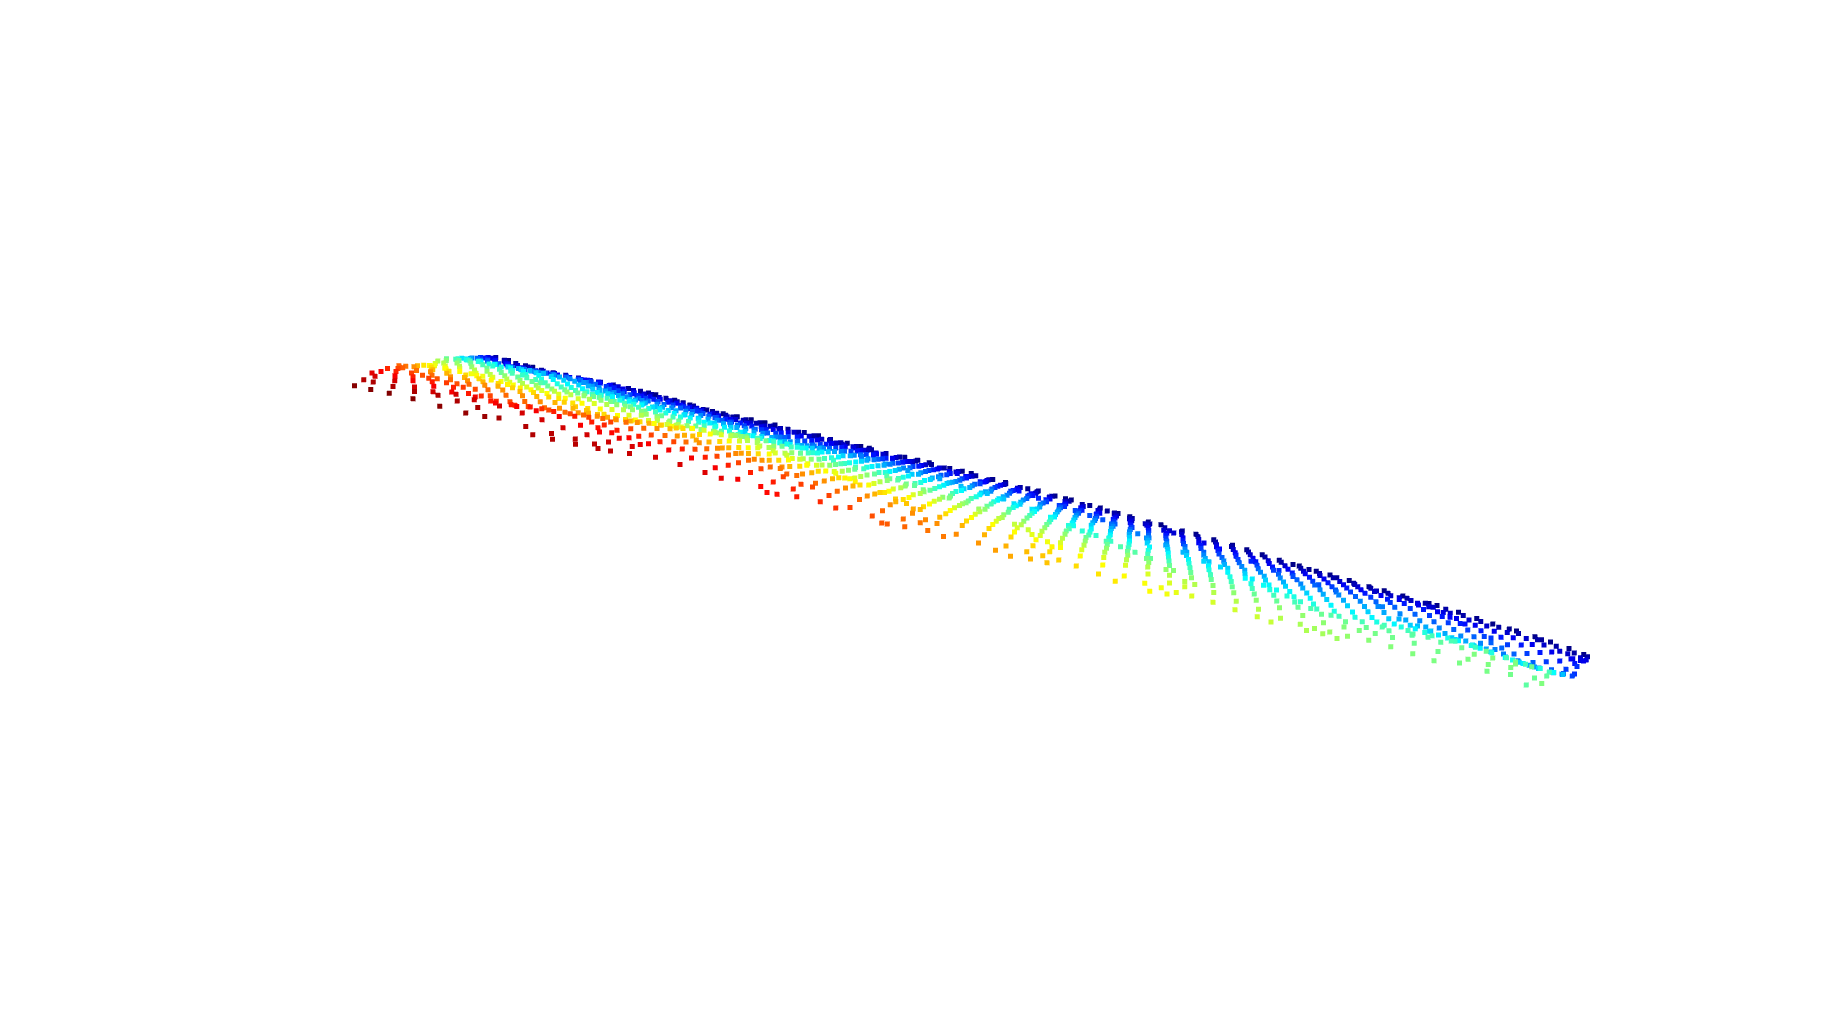

In [134]:
o3d.visualization.draw_geometries([downs], zoom=0.35)

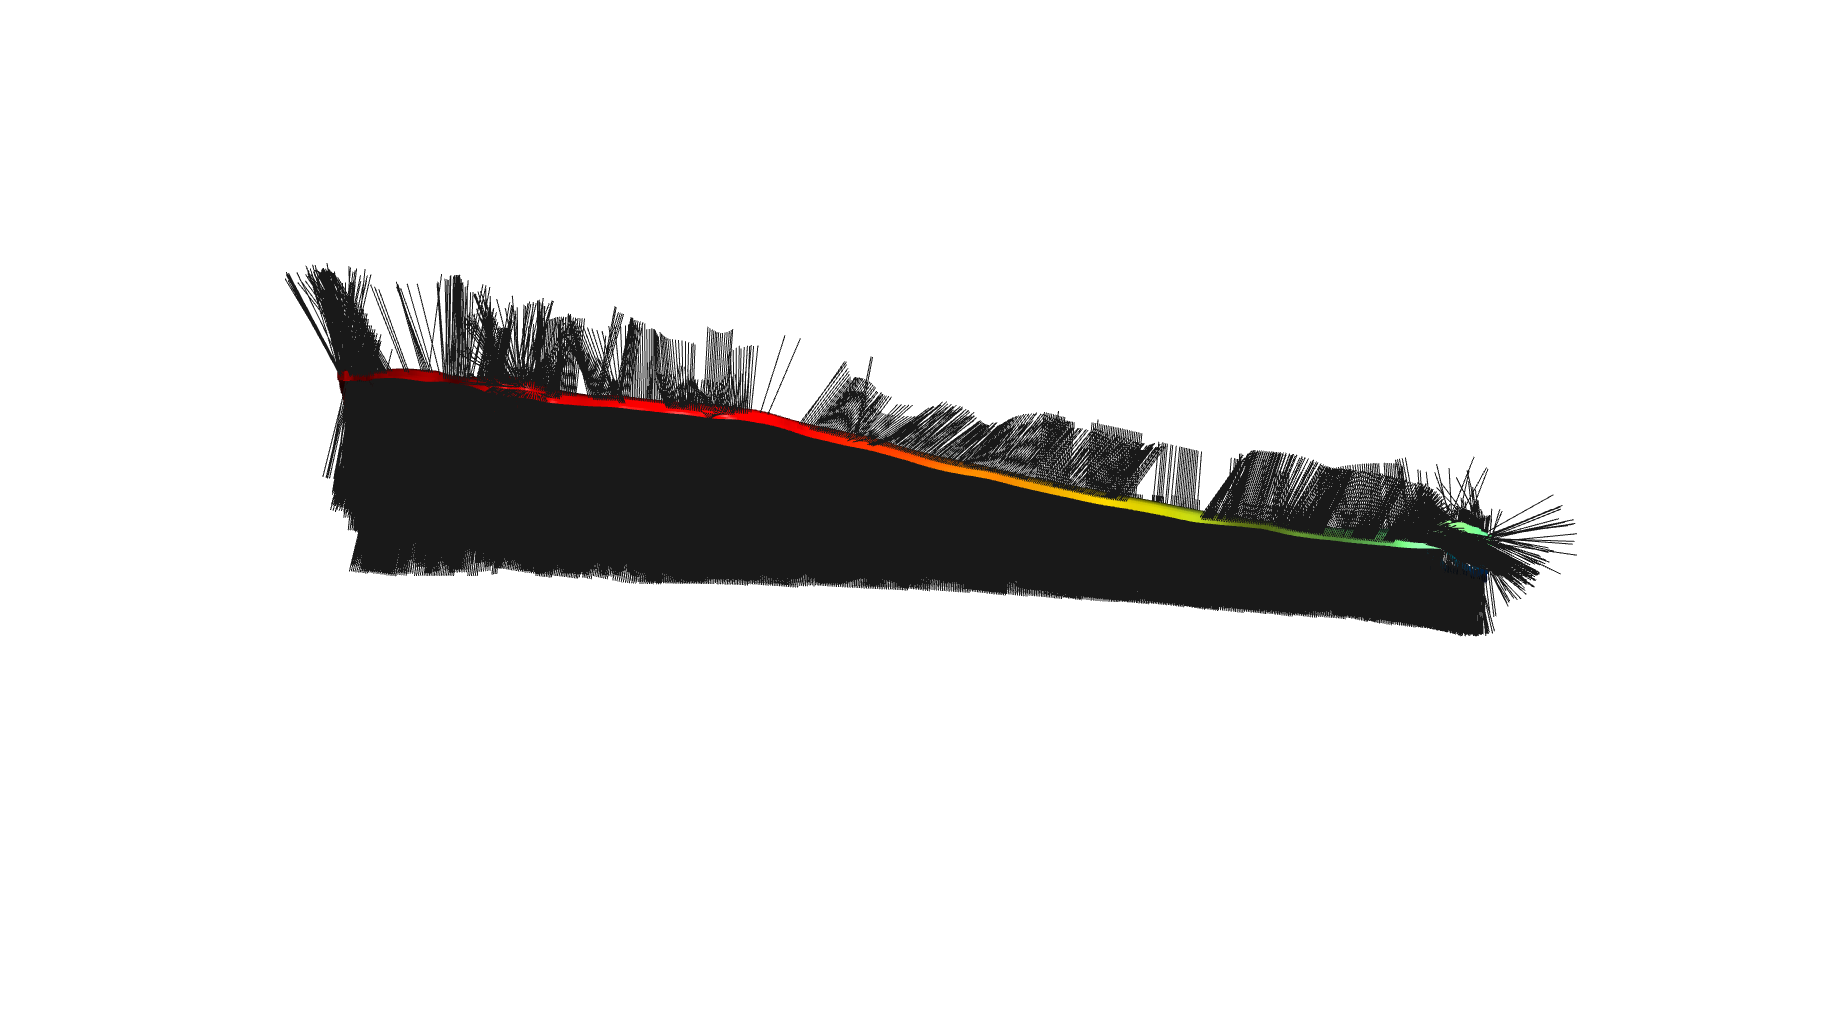

In [135]:
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))
o3d.visualization.draw_geometries([pcd], zoom=0.35)

Plane equation: 0.06x + 0.98y + -0.21z + 0.00 = 0


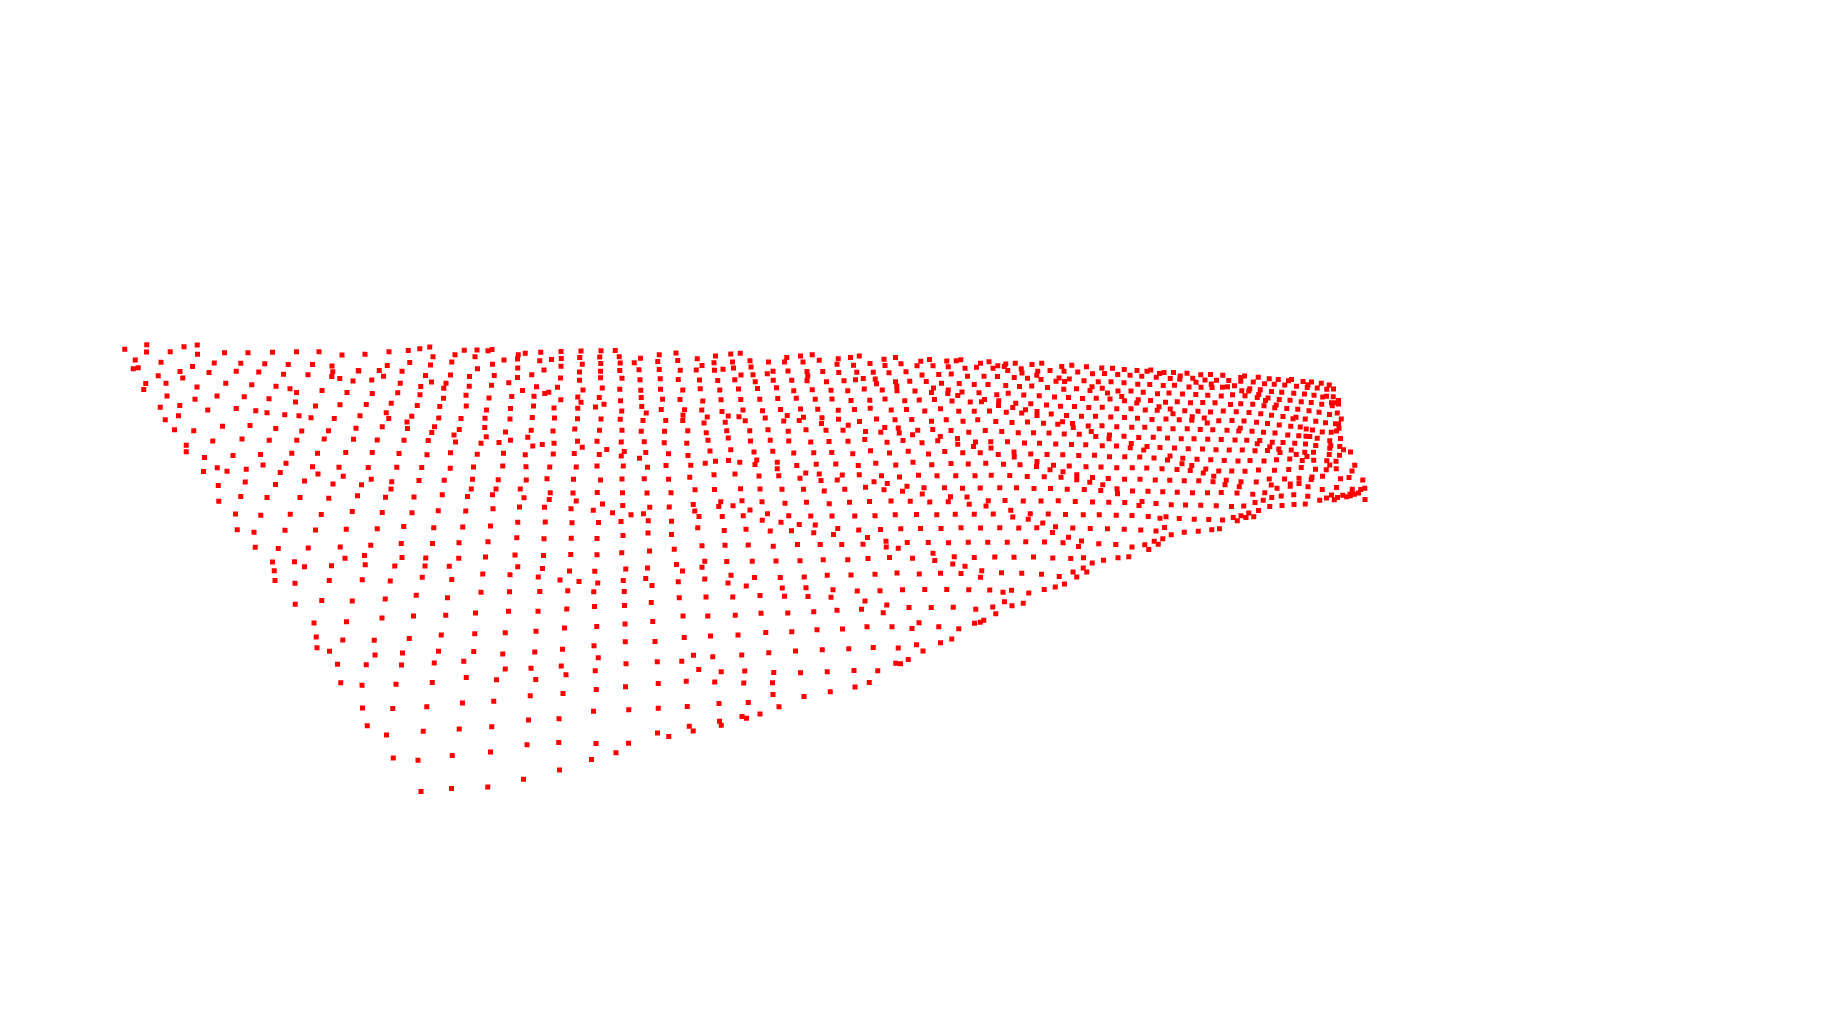

In [136]:
plane_model, inliers = downs.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=100)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = downs.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = downs.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [138]:
downs.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2, max_nn=30))


True

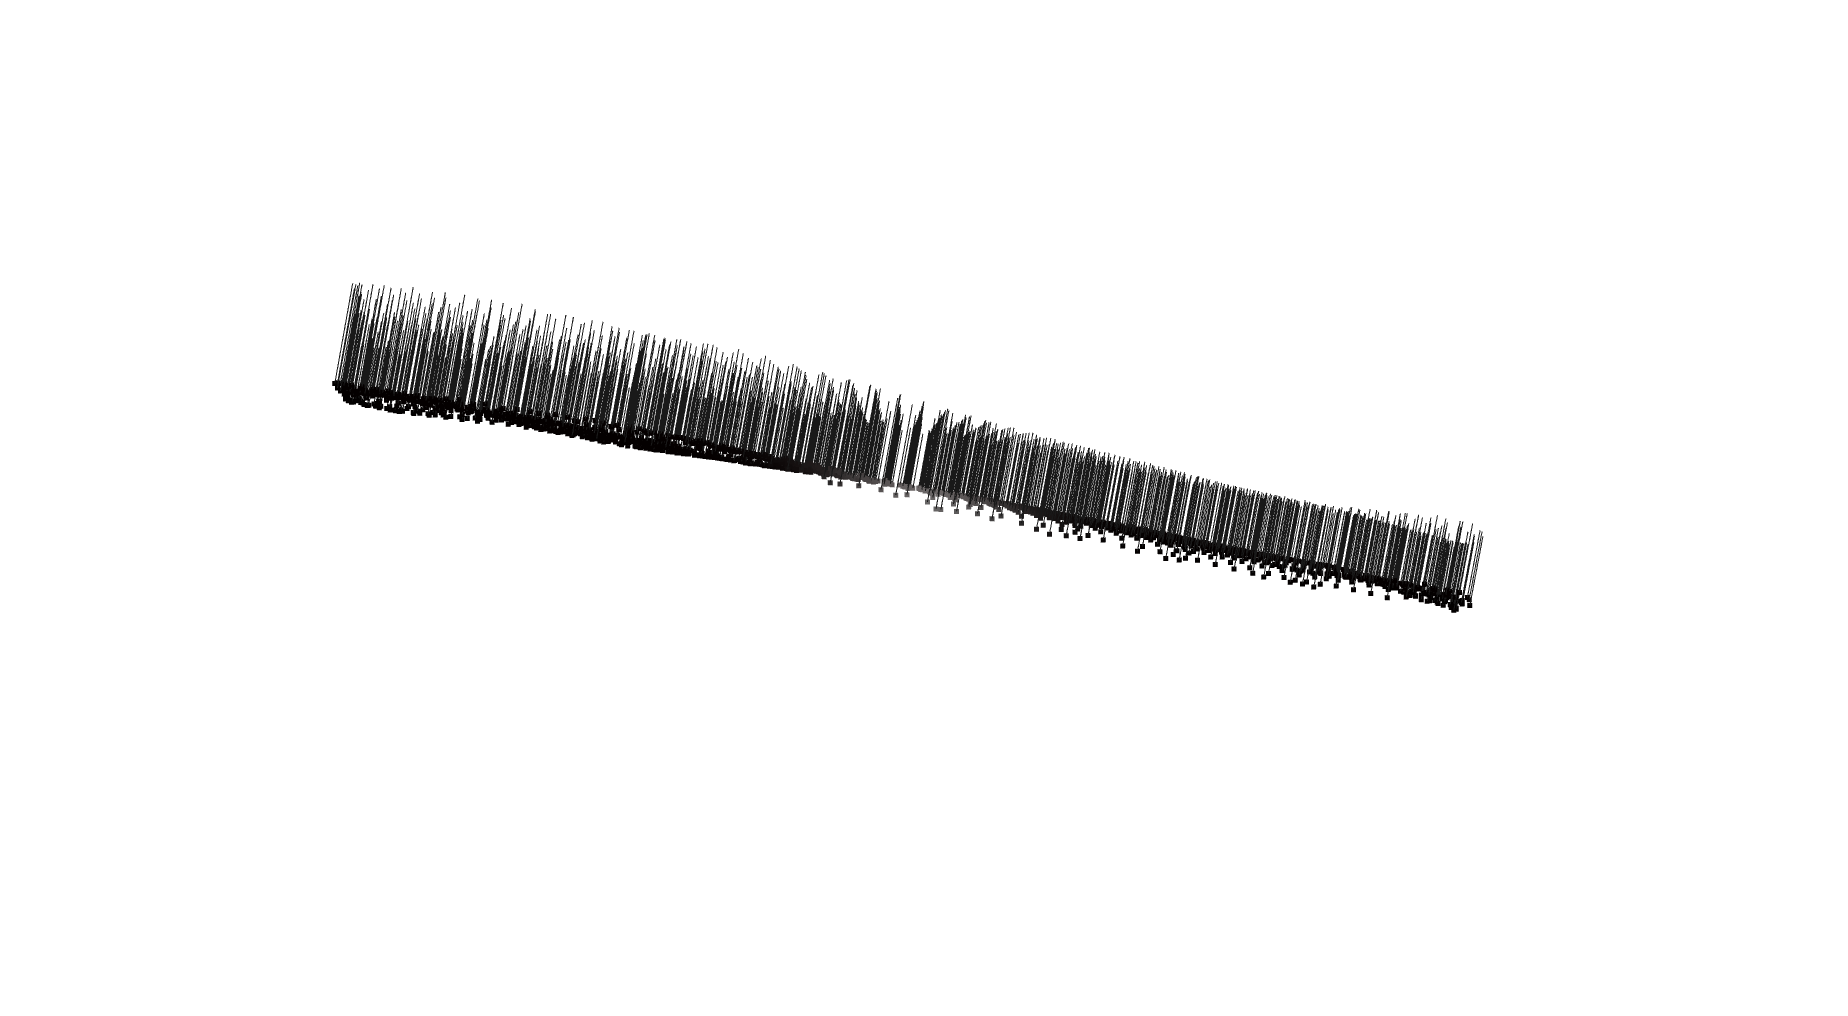

In [139]:
downs.normals = o3d.utility.Vector3dVector(np.array([np.array([a, b, c]) for _ in range(np.asarray(downs.normals).shape[0])]))

inlier_cloud1 = downs.select_by_index(inliers)
inlier_cloud1.paint_uniform_color([1.0, 0, 0])
outlier_cloud1 = downs.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud1, outlier_cloud1],
                                  zoom=0.35)

In [99]:
udowns = pcd.uniform_down_sample(4)

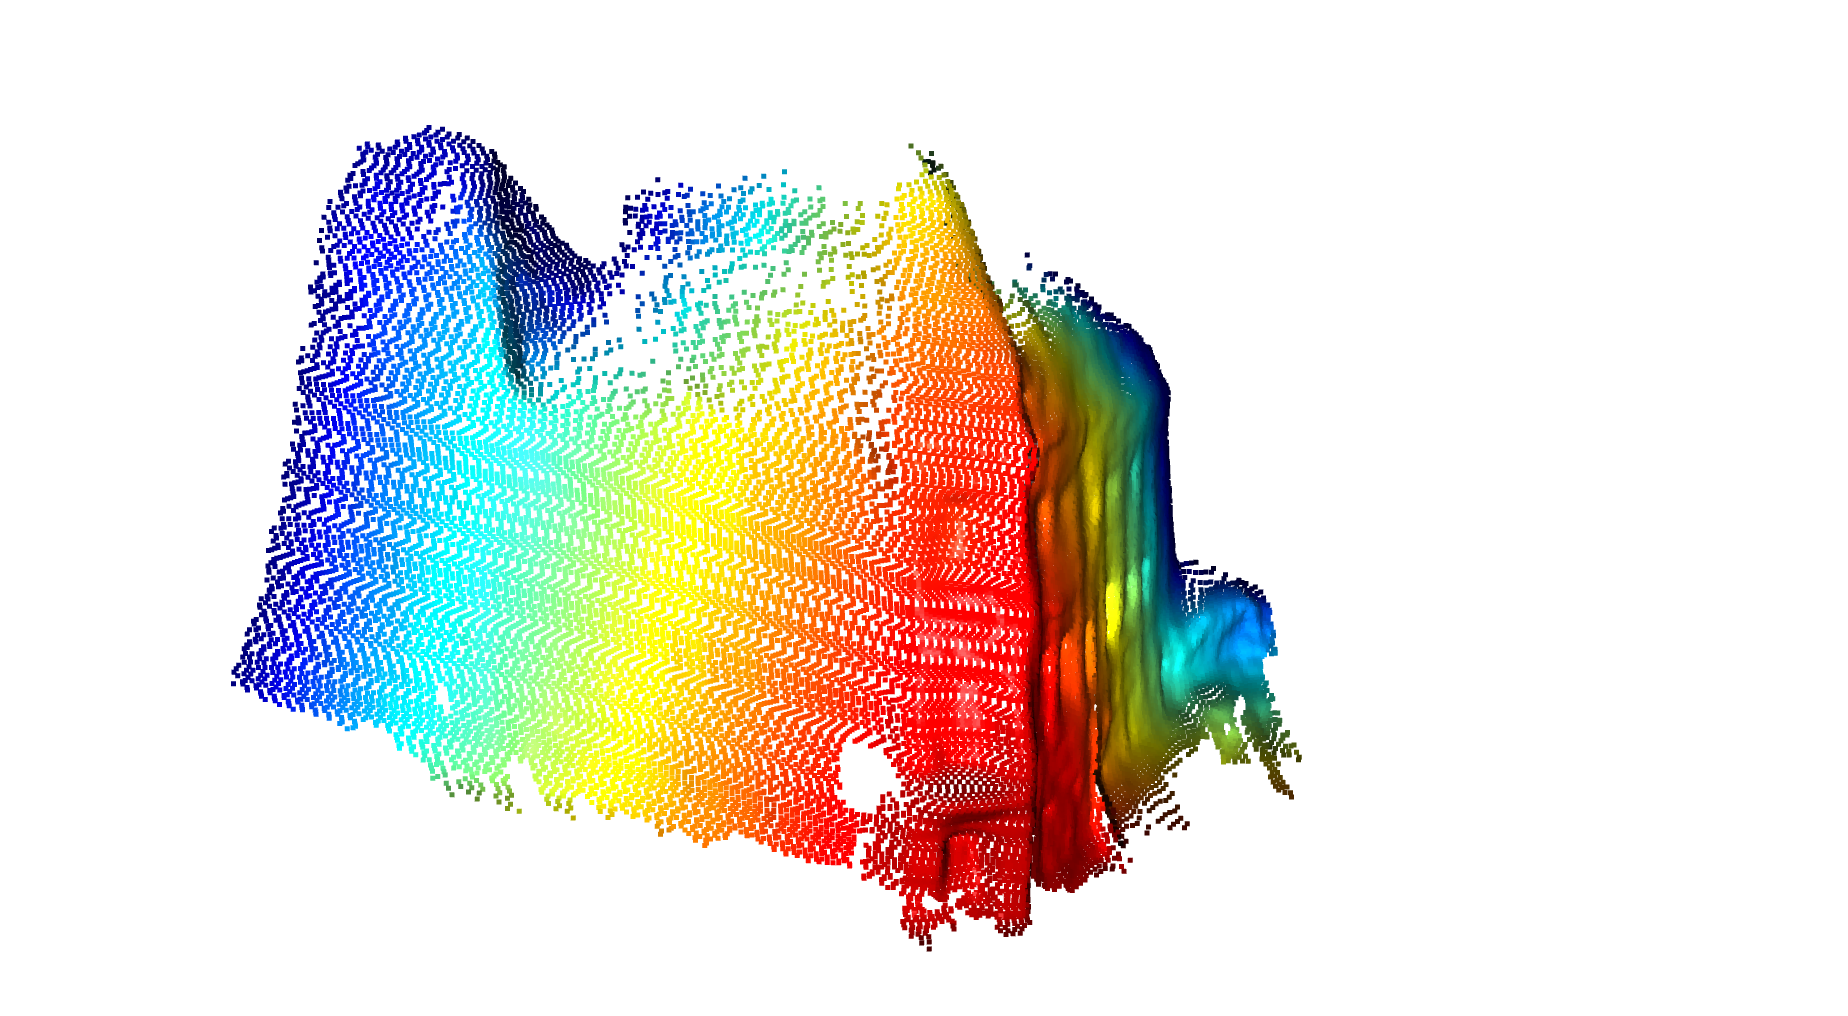

In [101]:
o3d.visualization.draw_geometries([udowns],
                                  zoom=0.35)

In [115]:
np.asarray(pcd.points).shape

(166889, 3)

Plane equation: 0.96x + 0.01y + 0.26z + 0.00 = 0


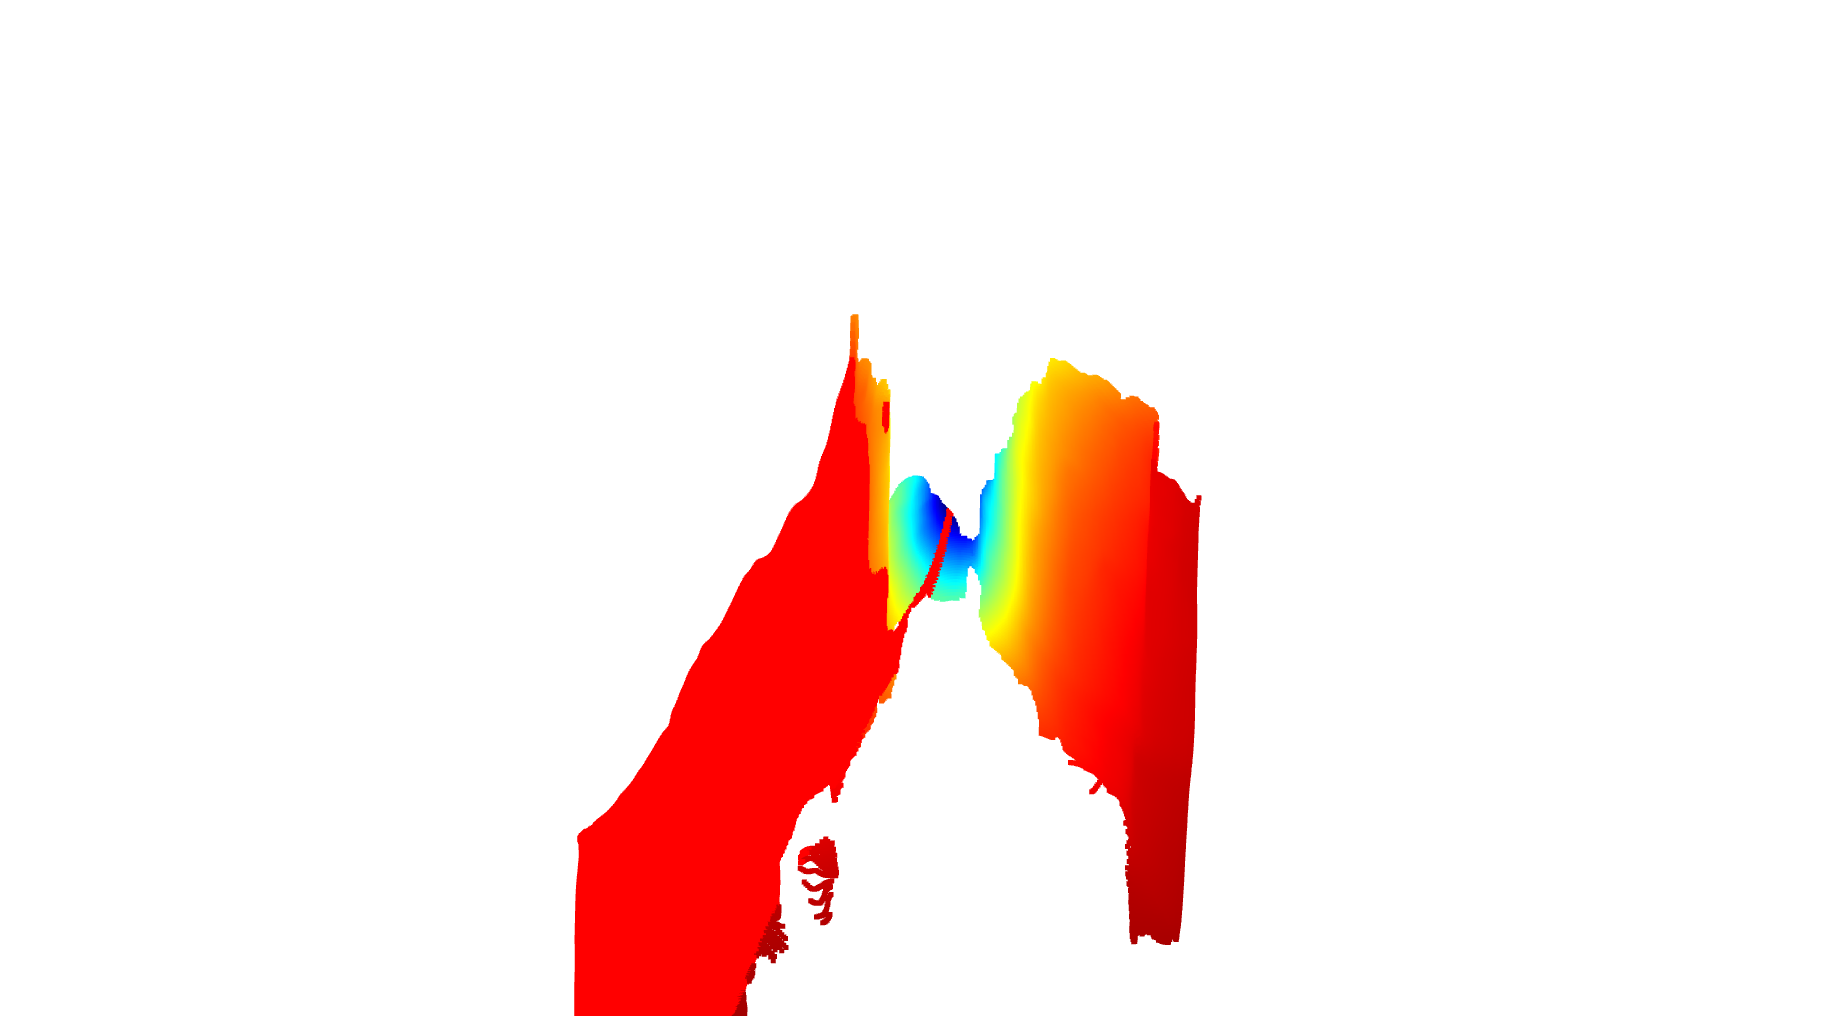

In [113]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=300)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [114]:
np.asarray(inlier_cloud.points).shape

(120666, 3)

Plane equation: 0.97x + -0.17y + 0.19z + -0.00 = 0


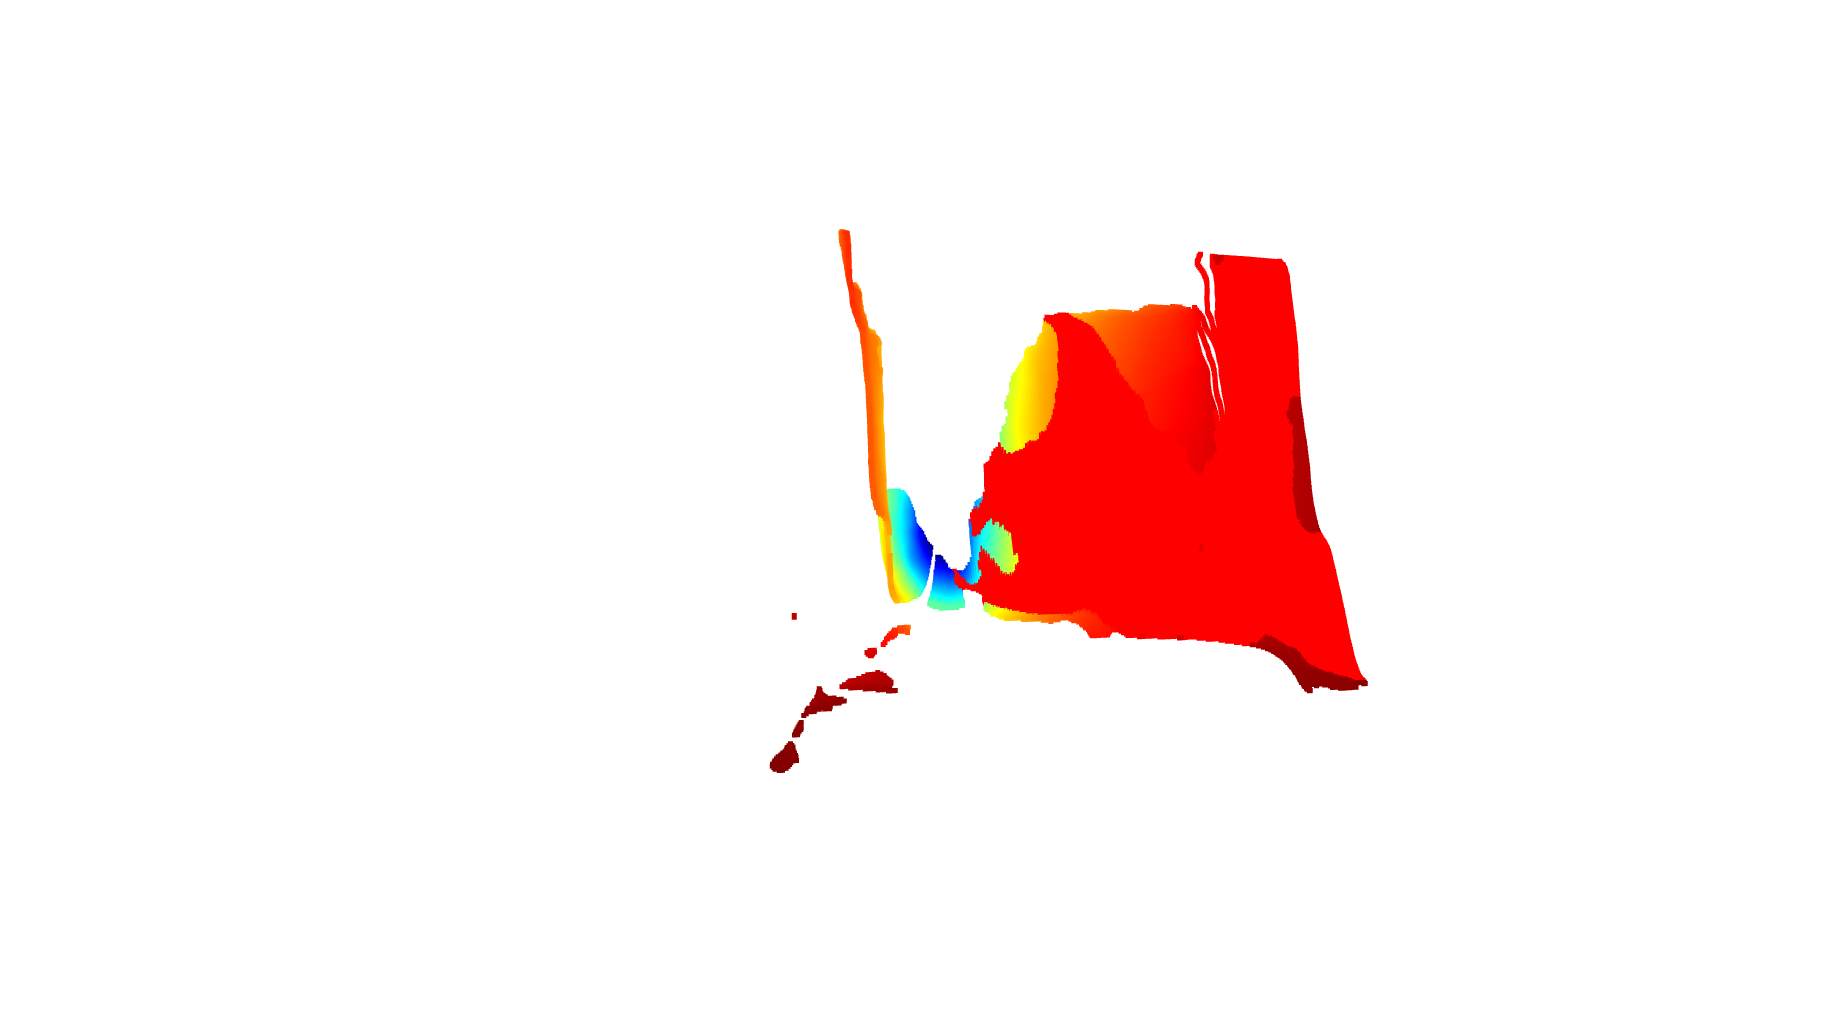

In [116]:
plane_model, inliers = outlier_cloud.segment_plane(distance_threshold=0.00002,
                                         ransac_n=3,
                                         num_iterations=300)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = outlier_cloud.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = outlier_cloud.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.35)
# Plane equation: 0.90x + -0.16y + 0.42z + 6.26 = 0


In [118]:
help(cv2.connectedComponentsWithAlgorithm)

Help on built-in function connectedComponentsWithAlgorithm:

connectedComponentsWithAlgorithm(...)
    connectedComponentsWithAlgorithm(image, connectivity, ltype, ccltype[, labels]) -> retval, labels
    .   @brief computes the connected components labeled image of boolean image
    .   
    .   image with 4 or 8 way connectivity - returns N, the total number of labels [0, N-1] where 0
    .   represents the background label. ltype specifies the output label image type, an important
    .   consideration based on the total number of labels or alternatively the total number of pixels in
    .   the source image. ccltype specifies the connected components labeling algorithm to use, currently
    .   Grana (BBDT) and Wu's (SAUF) algorithms are supported, see the #ConnectedComponentsAlgorithmsTypes
    .   for details. Note that SAUF algorithm forces a row major ordering of labels while BBDT does not.
    .   This function uses parallel version of both Grana and Wu's algorithms if at leas